# Compile companion data
In this notebook I compile all of the temperature measurements for each companion, de-bias the measurements using the relationships derived in [Gullikson et. al (2016)](http://adsabs.harvard.edu/abs/2016AJ....151....3G), and save the results to a csv file that is used in later analysis.

*NOTE*: The 2nd cell in this notebook reads in a spreadsheet with all of the raw companion data. This spreadsheet is not being released, so running the notebook will result in errors. It is included to view the process.

In [1]:
# Import a bunch of stuff
from kglib.utils import HelperFunctions, HDF5_Helpers
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt

from kglib.cross_correlation.GenericSearch import Process_Data
from kglib.utils.StarData import get_vsini
from collections import defaultdict
import os

import Analyze_CCF

logger = logging.getLogger()
logger.setLevel(logging.INFO)
%matplotlib inline

Module 'anfft' (FFTW Python bindings) could not be imported.
To install it, try running 'easy_install anfft' from the terminal.
Falling back on the slower 'fftpack' module for ND Fourier transforms.
rv/:
 continpars@    fxcor           rvcorrect       rvreidlines
 filtpars@      keywpars@       rvidlines


In [2]:
# Read the sample
sample = HelperFunctions.read_observed_targets()
sample.Temperature = pd.to_numeric(sample.Temperature, errors='coerce')
sample.loc[76, 'Temperature'] = np.nan  # I don't believe the 2nd detection for HIP 14764
sample.loc[137, 'Temperature'] = np.nan  # Bad temperature for 2nd detection of HIP 22958
detections = sample.loc[(sample.Temperature.notnull()) & (sample.Temperature < 90000)].copy()

detections.loc[detections.identifier == 'HIP 22958', ['Date', 'Temperature', 'vsini_sec', '[Fe/H]']]

,Date,Temperature,vsini_sec,[Fe/H]
136,20130915,5900,30,-0.5


In [3]:
# Set the addmode to use for everything to simple, except for one star where we need to use ml to detect...
detections['addmode'] = 'simple'
detections.loc[detections.identifier == 'HIP 18396', 'addmode'] = 'ml'

In [4]:
interface = HDF5_Helpers.Full_CCF_Interface(cache=False, update_cache=False, 
                                            cache_fname='/home/kgullikson/.PythonModules/CCF_metadata.csv')

In [5]:
starname, date, inst, addmode = 'HIP 22958', '2013-09-15', 'CHIRON', 'simple'
interface.get_measured_temperature(starname=starname, date=date, instrument=inst, 
                                   Tmax=5900, addmode=addmode, feh=-0.5, vsini=30)

INFO:root:HIP 22958, 2013-09-16, CHIRON, simple


,Tmeas,Tmeas_err,[Fe/H],logg,rv,significance,vsini,Star,Date,Instrument,addmode
0,5899.991984,216.006675,-0.5,4.5,43,12.488445,30,HIP 22958,2013-09-16,CHIRON,simple


# Get the measured temperature for every star

In [6]:
# Change instrument 'HRS' to 'HET', so the get_measured_temperature code works
detections.loc[detections.Instrument == 'HRS', 'Instrument'] = 'HET'

# Make a date string suitable for the HDF5 interface code
detections['parsed_date'] = detections.Date.astype(str).map(lambda s: '{}-{}-{}'.format(s[:4], s[4:6], s[6:8]))

# Get the updated information for each row
def get_tmeas(row):
    try:
        data = interface.get_measured_temperature(starname=row['identifier'],
                                                  date=row['parsed_date'],
                                                  instrument=row['Instrument'],
                                                  Tmax=row['Temperature'],
                                                  addmode=row['addmode'],
                                                  feh=row['[Fe/H]'],
                                                  vsini=row['vsini_sec'])
        Tmeas, Tmeas_err, sig = data.Tmeas.item(), data.Tmeas_err.item(), data.significance.item()
    except ValueError:
        print('Something weird happened with this row! Returning NaNs...')
        print(row)
        Tmeas, Tmeas_err, sig = np.nan, np.nan, np.nan
    #print(Tmeas, Tmeas_err, sig)
    return Tmeas, Tmeas_err, sig
out = detections.apply(get_tmeas, axis=1)

detections['Tmeas'], detections['Tmeas_err'], detections['significance'] = zip(*out)
detections[['identifier', 'SpT', 'configuration', 'Instrument', 'Date', 'Temperature', '[Fe/H]', 'vsini_sec', 'Tmeas', 'Tmeas_err', 'significance']].head()

INFO:root:HIP 2548, 2013-08-12, HET, simple
INFO:root:HIP 2548, 2015-08-06, IGRINS, simple
INFO:root:HIP 3478, 2014-01-12, TS23, simple
INFO:root:HIP 5310, 2014-10-15, IGRINS, simple
INFO:root:HR 545, 2014-10-15, IGRINS, simple
INFO:root:HR 545, 2013-10-21, TS23, simple
INFO:root:HR 545, 2014-01-11, TS23, simple
INFO:root:HR 604, 2013-10-20, TS23, simple
INFO:root:HIP 10732, 2014-10-15, IGRINS, simple
INFO:root:HIP 10732, 2015-03-02, IGRINS, simple
INFO:root:HIP 12332, 2014-10-17, IGRINS, simple
INFO:root:HIP 12332, 2014-01-20, TS23, simple
INFO:root:HIP 12706, 2014-10-16, IGRINS, simple
INFO:root:HIP 12706, 2013-10-19, TS23, simple
INFO:root:HIP 13165, 2013-08-14, HET, simple
INFO:root:HIP 13327, 2014-01-13, TS23, simple
INFO:root:HIP 14576, 2013-10-17, TS23, simple
/home/kgullikson/.PythonModules/gullikson-scripts/kglib/utils/HDF5_Helpers.py:429: UserWarning: No matches for T = 7100.0 with star/date = HIP 14576/2013-10-17!
  warnings.warn('No matches for T = {} with star/date = {}/{}

Something weird happened with this row! Returning NaNs...
identifier                                                  HIP 37450
RA/DEC (J2000)                          07 41 15.81255 -38 32 00.7166
plx                                                               5.5
Vmag                                                             5.41
Kmag                                                            5.784
vsini                                                             100
SpT                                                               B5V
configuration                                                     B5V
Instrument                                                     CHIRON
Date                                                      2.01311e+07
Temperature                                                     14000
Velocity                                                          NaN
vsini_sec                                                         NaN
[Fe/H]                          

,identifier,SpT,configuration,Instrument,Date,Temperature,[Fe/H],vsini_sec,Tmeas,Tmeas_err,significance
10,HIP 2548,B9.5V,(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.6...,HET,20130812,5600,-0.5,30,5600.047668,215.998031,29.055830
11,HIP 2548,B9.5V,(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.6...,IGRINS,20150806,6000,0.0,30,6000.008180,216.001275,8.796868
17,HIP 3478,B5V,B5V,TS23,20140112,5800,-0.5,5,5799.802745,215.990025,31.099362
30,HIP 5310,A3V,(A3V + ?; ?),IGRINS,20141014,3400,0.0,30,3399.871770,215.846391,13.244871
43,HR 545,B9.5IV,B9V,IGRINS,20141014,4500,-0.5,5,4499.706320,215.693513,36.996533


In [8]:
# Save to a file
cols = [u'identifier', u'SpT', u'configuration', u'Instrument', u'Date', u'Temperature',
        u'Velocity', u'vsini_sec', u'[Fe/H]', u'significance', 
        u'Comments', u'Rank', u'Keck', u'VLT', u'Gemini', 
        u'Imaging_Detecton', u'addmode', u'parsed_date', u'Tmeas', u'Tmeas_err']
detections[cols].to_csv('data/Companion_Data.csv', 
                        encoding='utf-8', sep='|')

In [25]:
df = pd.read_csv('data/Companion_Data.csv', sep='|', index_col=0)
df.rename(columns=dict(identifier='Star'), inplace=True)

,Star,SpT,configuration,Instrument,Date,Temperature,Velocity,vsini_sec,[Fe/H],significance,Comments,Rank,Keck,VLT,Gemini,Imaging_Detecton,addmode,parsed_date,Tmeas,Tmeas_err


In [12]:
# Correct temperatures (de-bias them)
corrected = interface.convert_measured_to_actual(df)

$T = 5272.91234483^{+154.319627832}_{-154.294218303}$
$T = 5272.91234483^{+154.319627832}_{-154.294218303}$
$T = 5374.49917259^{+154.367282969}_{-154.338624796}$
$T = 5069.99133526^{+154.259757481}_{-154.241285088}$
$T = 4512.15999034^{+158.042540213}_{-158.047151728}$
$T = 4664.2295086^{+154.09852706}_{-154.095237427}$
$T = 4664.26476895^{+154.03384013}_{-154.030549511}$
$T = 5476.13470202^{+154.376832897}_{-154.345101151}$
$T = 5679.34581761^{+154.416436669}_{-154.379150558}$
$T = 5866.28899692^{+158.204650655}_{-158.190731892}$
$T = 5554.33789808^{+158.179901241}_{-158.170358032}$
$T = 4561.9199909^{+154.107638595}_{-154.108349244}$
$T = 4341.28785624^{+149.631144988}_{-149.637086437}$
$T = 4341.04392587^{+149.604084327}_{-149.610027157}$
$T = 5032.46074812^{+158.157458002}_{-158.155061281}$
$T = 4720.59637308^{+158.130824922}_{-158.132635493}$
$T = 5069.8225407^{+154.349468166}_{-154.330998739}$
$T = 5577.94796668^{+154.40541222}_{-154.370792129}$
$T = 5524.58490656^{+149.745678521

In [13]:
corrected[['Star', 'Corrected_Temperature', 'T_lowerr', 'T_uperr']].head(5)

,,Star,Corrected_Temperature,T_lowerr,T_uperr
Star,,,,,
HIP 100221,0,HIP 100221,5272.912345,154.294218,154.319628
HIP 100907,0,HIP 100907,5222.166737,109.099192,109.111095
HIP 103298,0,HIP 103298,4615.260623,89.693332,89.693126
HIP 10732,0,HIP 10732,5577.720977,109.152286,109.169737
HIP 109139,0,HIP 109139,5710.302372,111.851036,111.856900


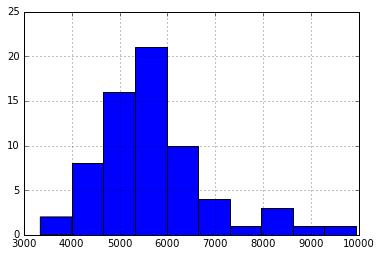

In [14]:
corrected.Corrected_Temperature.hist()

In [19]:
# Make a few interpolators from spectral type relations
from kglib.spectral_type import Mamajek_Table, SpectralTypeRelations
MS = SpectralTypeRelations.MainSequence()
MT = Mamajek_Table.MamajekTable()

sptnum2mass = MT.get_interpolator('SpTNum', 'Msun')
teff2mass = MT.get_interpolator('Teff', 'Msun')

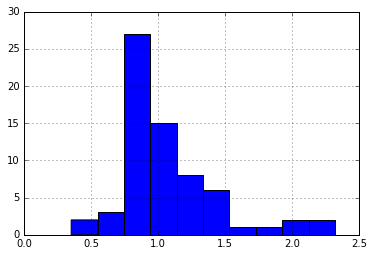

In [17]:
corrected['Mass'] = corrected.Corrected_Temperature.map(teff2mass)
corrected['Mass'].hist()

In [18]:
combined = pd.merge(df, corrected.reset_index(drop=True), on='Star', how='left')
combined.head()

,identifier,SpT,configuration,Instrument,Date,Temperature,Velocity,vsini_sec,[Fe/H],significance,...,Imaging_Detecton,addmode,parsed_date,Tmeas,Tmeas_err,Star,Corrected_Temperature,T_lowerr,T_uperr,Mass
0,HIP 2548,B9.5V,(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.6...,HET,20130812,5600,6.985,30,-0.5,29.055830,...,NaN,simple,2013-08-12,5600.047668,215.998031,HIP 2548,5731.871044,111.944200,111.970164,0.999838
1,HIP 2548,B9.5V,(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.6...,IGRINS,20150806,6000,2.853,30,0.0,8.796868,...,NaN,simple,2015-08-06,6000.008180,216.001275,HIP 2548,5731.871044,111.944200,111.970164,0.999838
2,HIP 3478,B5V,B5V,TS23,20140112,5800,-46.170,5,-0.5,31.099362,...,NaN,simple,2014-01-12,5799.802745,215.990025,HIP 3478,5524.167448,149.776982,149.777760,0.957467
3,HIP 5310,A3V,(A3V + ?; ?),IGRINS,20141014,3400,4.825,30,0.0,13.244871,...,NaN,simple,2014-10-14,3399.871770,215.846391,HIP 5310,3342.903730,154.342363,154.296476,0.352680
4,HR 545,B9.5IV,B9V,IGRINS,20141014,4500,-34.854,5,-0.5,36.996533,...,NaN,simple,2014-10-14,4499.706320,215.693513,HR 545,4312.198360,87.253151,87.250229,0.728464


In [31]:
# Save corrected temperatures to disk
sptnum = combined.SpT.map(MS.SpT_To_Number)
combined['M1'] = sptnum.map(sptnum2mass)
combined.to_csv('/home/kgullikson/School/Research/BinaryInference/data/Corrected_Companion_Data.csv', 
                sep='|', encoding='utf-8')
combined[['Star', 'SpT', 'configuration', 'M1', 'Temperature', 'Corrected_Temperature', 'Mass']].head()

,Star,SpT,configuration,M1,Temperature,Corrected_Temperature,Mass
0,HIP 2548,B9.5V,(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.6...,2.5,5600,5731.871044,0.999838
1,HIP 2548,B9.5V,(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.6...,2.5,6000,5731.871044,0.999838
2,HIP 3478,B5V,B5V,4.6,5800,5524.167448,0.957467
3,HIP 5310,A3V,(A3V + ?; ?),2.0,3400,3342.903730,0.352680
4,HR 545,B9.5IV,B9V,2.5,4500,4312.198360,0.728464


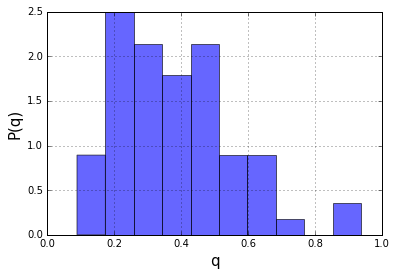

In [28]:
combined['q'] = combined.Mass / combined.M1
combined.drop_duplicates(subset=['Star'])['q'].hist(alpha=0.6, normed=True)
plt.xlabel('q', fontsize=15)
plt.ylabel('P(q)', fontsize=15)
#qplot = np.arange(0.05, 1, 0.01)
#gamma = 0.2
#plt.plot(qplot, (1-gamma)*qplot**(-gamma), 'r-', lw=3, alpha=0.6)
plt.savefig('Figures/MyMassRatios.pdf')